In [1]:
import pandahouse as ph
import numpy as np
import seaborn as sns

import scipy.stats as stats
from tqdm.notebook import tqdm

In [2]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'xxx',
    'user': 'xxx',
    'database': 'xxx'
}

In [3]:
query = """
select
  user_id,
  exp_group,
  countIf(user_id, action = 'like') as likes,
  countIf(user_id, action = 'view') as views,
  likes / views as ctr
from
  {db}.feed_actions
where
  toDate(time) between '2023-01-31'
  and '2023-02-06'
  and exp_group in (0,3,1,2)
group by
  exp_group,
  user_id
"""

df = ph.read_clickhouse(query, connection=connection)

In [4]:
df.head(3)

,user_id,exp_group,likes,views,ctr
0,115383,3,9,30,0.300000
1,18392,1,7,32,0.218750
2,123580,3,13,48,0.270833


In [5]:
df.shape

(40079, 5)

### Общее

Поскольку в задании не указано какая из групп контрольная, то выберем по аналогии со вторым заданием, где сначала указывалась группа с внедрением нового алгоритма постов, а потом указывалась контрольная группа.

 - 0 - основная, 3 - контрольная
 - 1 - основная, 2 - контрольная
 
**Задача**
 - Проанализируйте тест между группами 1 и 2 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?
 
Вывод: визуальные отличия в распределении имеются. Видно отличие значений p-value. Если не использовать линеаризацию, то статистическая значимость не определяется (p-value 0.478). При использовании линеаризации наблюдается статистически значимое различие в группах (p-value 5.9 * 10<sup>-10</sup>).

## Эксперимент для групп 0 и 3

In [6]:
# выбираем всех пользователей из 1 и 2 групп
exp_12_df = df[df['exp_group'].isin((1, 2))].copy()
exp_12_df.shape

(20031, 5)

In [7]:
exp_12_df.head(3)

,user_id,exp_group,likes,views,ctr
1,18392,1,7,32,0.218750
3,131473,2,14,134,0.104478
4,32420,2,26,128,0.203125


In [8]:
exp_12_df['exp_group'].value_counts()

1    10079
2     9952
Name: exp_group, dtype: int64

In [9]:
# считаем CTRcontrol для 2-ей группы
users_g2 = exp_12_df[exp_12_df['exp_group'] == 2].copy()
ctr_control_g2 = sum(users_g2['likes']) / sum(users_g2['views'])
ctr_control_g2

0.1980601844115994

In [10]:
# linearized_likes для каждого пользователя из 0 и 3 групп
exp_12_df['linearized_likes'] = exp_12_df['likes'] - ctr_control_g2 * exp_12_df['views']

In [11]:
exp_12_df.head(3)

,user_id,exp_group,likes,views,ctr,linearized_likes
1,18392,1,7,32,0.218750,0.662074
3,131473,2,14,134,0.104478,-12.540065
4,32420,2,26,128,0.203125,0.648296


In [12]:
# подготовка к сравнению Т-тестом
ctr_g1 = exp_12_df[exp_12_df['exp_group'] == 1]['ctr'].copy().values
ctr_g2 = exp_12_df[exp_12_df['exp_group'] == 2]['ctr'].copy().values

ctr_linearized_g1 = exp_12_df[exp_12_df['exp_group'] == 1]['linearized_likes'].copy().values
ctr_linearized_g2 = exp_12_df[exp_12_df['exp_group'] == 2]['linearized_likes'].copy().values

In [13]:
ctr_g1.shape, ctr_g2.shape, ctr_linearized_g1.shape, ctr_linearized_g2.shape

((10079,), (9952,), (10079,), (9952,))

### Сравнение Т-тестом выборок

Сравним значения p-value по метрике CTR и CTRlinearized

In [14]:
statistica, p_value = stats.ttest_ind(a=ctr_g1,
                                      b=ctr_g2,
                                      equal_var=False)

statistica_linearized, p_value_linearized = stats.ttest_ind(a=ctr_linearized_g1,
                                                            b=ctr_linearized_g2,
                                                            equal_var=False)

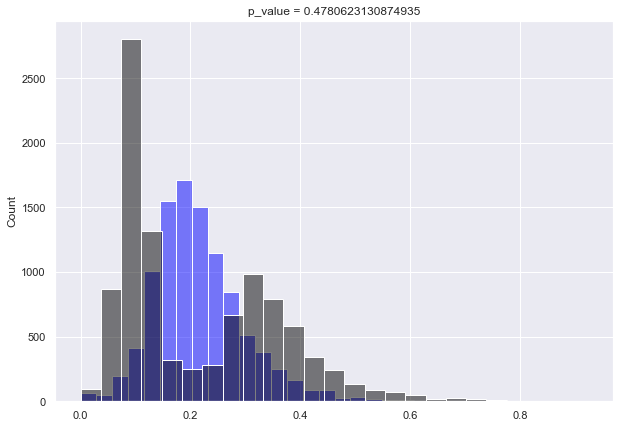

In [18]:
sns.set_theme(rc={'figure.figsize': (10, 7)})

# для наглядности, зададим кол-во интервалов вручную
bins = 25

ax = sns.histplot(data=ctr_g1,
                  color='blue',
                  alpha=0.5,
                  bins=bins);

sns.histplot(data=ctr_g2,
             color='black',
             alpha=0.5,
             bins=bins,
             ax=ax);

ax.set_title(f'p_value = {p_value}');

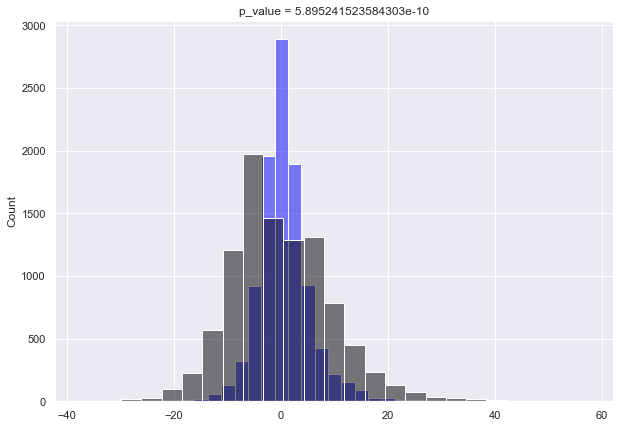

In [19]:
ax_linearized = sns.histplot(data=ctr_linearized_g1,
                             color='blue',
                             alpha=0.5,
                             bins=bins);

sns.histplot(data=ctr_linearized_g2,
             color='black',
             alpha=0.5,
             bins=bins,
             ax=ax_linearized);

ax_linearized.set_title(f'p_value = {p_value_linearized}');

In [17]:
p_value_linearized < p_value

True